# Présentation de la librairie open source Geemap pour la visualisation et le pré-traitement d'images satellites à partir de Google Earth Engine.

* [**Google Earth Engine (GEE)**](https://earthengine.google.com/) : plateform regroupant plusieurs bases de données de télédétection


* [**Geemap**](https://geemap.org/) : bibliothèque python pour la visualisation et le traitement des données GEE. 

**Attention** : l'utilisation de Google Earth Engine requiert un compte google ... 

## Installation 

Installer Miniconda ou Anaconda puis :

* `conda create -n env_name`
* `conda activate env_name`
* `conda install -c conda-forge gdal`
* `pip install geemap localtileserver`
* `pip install scikit-learn geopandas`

## Utilisation de la carte 

Geemap dispose de plusieurs backend pour la visualisation. Le backend par défaut est ipyleaflet, voyons ce qu'on y trouve :

* Une carte du monde ...
* Une couche Google Map
* Outils de dessin
* Outils de mesure de distance

Mais aussi (haut à gauche): 

* Recherche par adresse
* Recherche par lat/lon
* Accès direct à la base de données GEE

Et encore (haut droite)

* Outils d'actions sur la carte
    - Repérage
    - Affichage de statistique
    - Sauvegarder
    - Effacer
    - JS à Python
    
* Gestionnaire de couches

In [1]:
import geemap
import ee
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DOWNLOAD = False

In [3]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

<IPython.core.display.Javascript object>

In [4]:
dataset = ee.Image("DLR/WSF/WSF2015/v1")

opacity = 0.75
blackBackground = ee.Image(0)
Map.addLayer(blackBackground, None, "Black background", True, opacity)

visualization = {
  'min': 0,
  'max': 255,
}
Map.addLayer(dataset, visualization, "Human settlement areas")

Map.setCenter(90.45, 23.7, 7)

In [16]:
#*
# Function to mask clouds using the Sentinel-2 QA band
# @param {ee.Image} image Sentinel-2 image
# @return {ee.Image} cloud masked Sentinel-2 image
#
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
      .And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

# Map the function over a month of data and take the median.
# Load Sentinel-2 TOA reflectance data (adjusted for processing changes
# that occurred after 2022-01-25).
dataset = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
                  .filterDate('2022-01-01', '2022-01-31') \
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
                  .map(maskS2clouds)

rgbVis = {
  'min': 0.0,
  'max': 0.3,
  'bands': ['B4', 'B3', 'B2'],
}

Map.setCenter(3.826711013082755, 43.47126702110463, 12)
Map.addLayer(dataset.median(), rgbVis, 'RGB')

## Récupération des données :  

Nous allons entrainer un modèle à estimer la population à partir d'images satellites Sentinel-2, puis visualiser les résultats sur une carte. 

### Choix de la zone d'étude

In [8]:
import geemap as geemap

Map = geemap.Map()

topleft = [3.741, 43.679]
bottomright = [4.274, 43.490]
center = np.mean([topleft, bottomright], axis=0)
mtp_bbox = ee.Geometry.Rectangle([topleft, bottomright])

Map.addLayer(mtp_bbox, {}, 'Montpellier BBox')
Map.addLayer(ee.Geometry.Point(topleft))
Map.addLayer(ee.Geometry.Point(bottomright))
Map.setCenter(*center, 10)
Map

Map(center=[43.584500000000006, 4.0075], controls=(WidgetControl(options=['position', 'transparent_bg'], widge…

<IPython.core.display.Javascript object>

### Visualisation des données Sentienl-2

On liste 3 parties : 

1. Une fonction qui permet de masquer les zones nuageuses lors de la visualisation
2. Une partie pour récupérer les données
3. Une partie pour visualiser les données 

In [9]:
#*
 # Function to mask clouds using the Sentinel-2 QA band
 # @param {ee.Image} image Sentinel-2 image
 # @return {ee.Image} cloud masked Sentinel-2 image
 #

#-----Earth Engine ----------------#

def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10 
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
      .And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
                  .filterDate('2020-01-01', '2020-12-31') \
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
                  .map(maskS2clouds)

#-----Geemap ----------------------#

visualization = {
  'min': 0.0,
  'max': 0.3,
  'bands': ['B4', 'B3', 'B2'],
}

Map.setCenter(*center, 12)
Map.addLayer(dataset.median(), visualization, name='RGB')

### Récupération des données Sentinel-2

On peut récupérer un composite médian sur toute la période temporelle : 

In [10]:
scale_10 = 10
scale_90 = 90

In [11]:
if DOWNLOAD:
    img = dataset.median().unmask() #unmask : nan --> 0.
    geemap.ee_export_image_to_drive(img, scale=scale_10, description=f'montpellier_{scale_10}', region=mtp_bbox)

In [12]:
if DOWNLOAD:
    geemap.ee_export_image_to_cloud_storage(img, scale=scale_90, description=f'montpellier_{scale_90}', bucket='landsat_images', region=mtp_bbox)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(234, 660, 3)


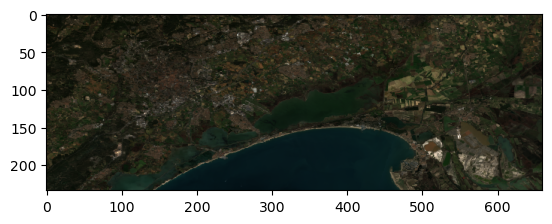

In [13]:
import rasterio
with rasterio.open('montpellier/montpellier_90.tif', 'r') as tif:
    img = tif.read()
    img = np.moveaxis(img*2, 0, -1)[:, :, [3, 2, 1]]
print(img.shape)
plt.imshow(img)

(2108, 5934, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


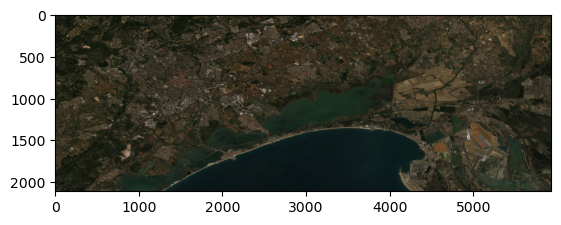

In [14]:
with rasterio.open('montpellier/montpellier_10.tif', 'r') as tif:
    img = tif.read()
    img = np.nan_to_num(img)
    img = np.moveaxis(img*2, 0, -1)[:, :, [3, 2, 1]]
print(img.shape)
plt.imshow(img)

On peut récupérer une collection d'image, correspondant à un composite médian par mois

In [15]:
if DOWNLOAD:
    one_image_per_month = []

    for month in range(1, 13):

        dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
                      .filterDate(f'2020-{month:02}-01', f'2020-{month:02}-28') \
                      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
                      .map(maskS2clouds)

        one_image_per_month.append(dataset.median())

    one_image_per_month = ee.ImageCollection(one_image_per_month)

    geemap.ee_export_image_collection_to_cloud_storage(one_image_per_month,
                                                scale=scale_10,
                                                bucket='landsat_images',
                                                region=mtp_bbox,
                                                )

In [22]:
monthly_images = []

for i in range(6):
    with rasterio.open(f'montpellier/monthly/{i}.tif', 'r') as tif:
        img = tif.read()
        img = np.nan_to_num(img, 0)  
    monthly_images.append(img)
monthly_images = np.array(monthly_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


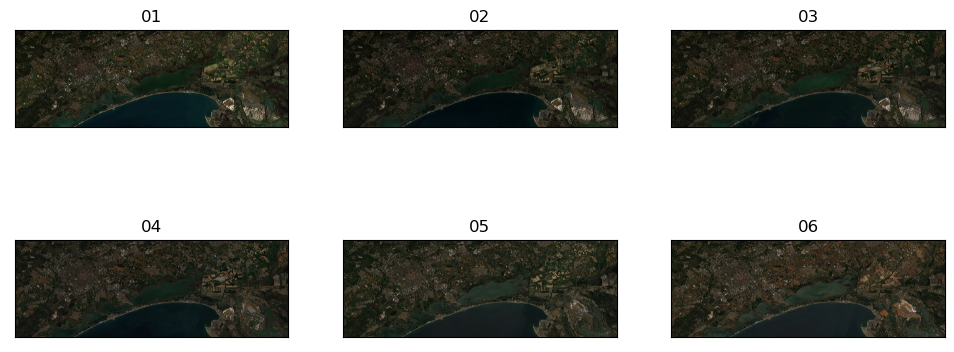

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5))

for i, (img, ax) in enumerate(zip(monthly_images, axes.flatten())):
    img = np.moveaxis(img, 0, -1)[:, :, [3, 2, 1]]
    img /= img.max()
    ax.imshow(img*3)
    ax.set_title(f'{i+1:02}')
    ax.set_xticks([])
    ax.set_yticks([])

### Récupération des données WorldPop

In [16]:
world_pop = ee.ImageCollection("WorldPop/GP/100m/pop") \
    .filterDate('2020-01-01', '2020-12-31') \


visualization = {
  'bands': ['population'],
  'min': 0.0,
  'max': 50.0,
  'palette': ['24126c', '1fff4f', 'd4ff50']
}

Map.addLayer(world_pop, visualization, 'Population')

In [17]:
Map

Map(bottom=95988.0, center=[43.636075155965784, 4.033331361895445], controls=(WidgetControl(options=['position…

In [23]:
if DOWNLOAD:
    img = world_pop.median().unmask() #unmask : nan --> 0.
    geemap.ee_export_image_to_cloud_storage(img, scale=scale_10, bucket='landsat_images', description=f'montpellier_wp_{scale_10}', region=mtp_bbox)

In [18]:
with rasterio.open('montpellier/montpellier_wp_10.tif') as tif:
    img = tif.read()
    img = np.squeeze(img)

print(img.shape)

(2108, 5934)


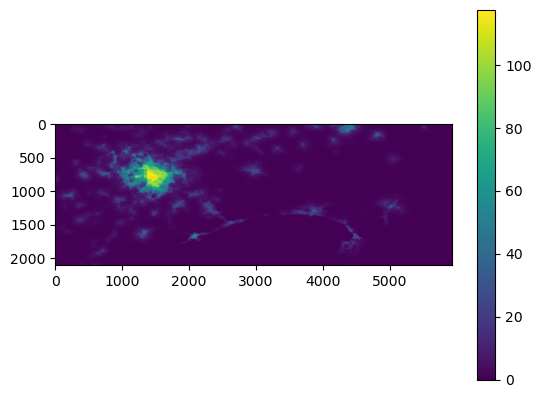

In [19]:
plt.imshow(img)
plt.colorbar()

## Traitement des données

On a récupéré 3 types de données pour la zone d'étude: 

* Un composite médian Sentinel-2 pour l'année 2020
* Une carte de population Worldpop

Voyons s'il est possible d'estimer la population avec les données Sentinel-2 

### Traitement des données Sentinel-2

In [20]:
with rasterio.open('montpellier/montpellier_10.tif', 'r') as tif:
    X = tif.read()
    X = np.nan_to_num(X)
print(X.shape)

(23, 2108, 5934)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


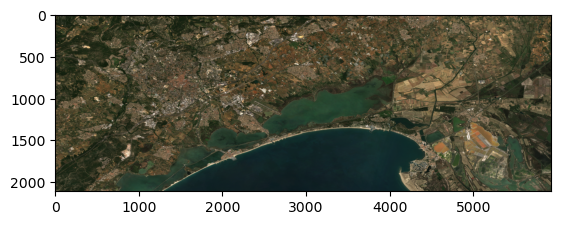

In [20]:
plt.imshow(np.moveaxis(X[[3, 2, 1]]*3, 0, -1))

In [21]:
X = np.moveaxis(X[[3, 2, 1]]*3, 0, -1)
#X = np.moveaxis(X[[3,2,1,8, 9, 10, 11, 12]], 0, -1)
h, w, n_c = X.shape

In [22]:
X.shape

(2108, 5934, 3)

On fait une partition train/test très simple, on entraine sur la portion d'image avant la colonne 4000 et on test après.

In [22]:
col_stop = 4000
X_train = X[:, :col_stop, :]
X_test = X[:, col_stop:, :]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Test')

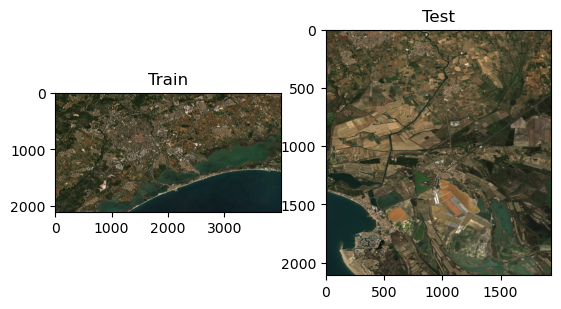

In [24]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(X_train)
ax[0].set_title('Train')
ax[1].imshow(X_test)
ax[1].set_title('Test')

### Traitement des données WorldPop

In [23]:
with rasterio.open('montpellier/montpellier_wp_10.tif', 'r') as tif:
    Y = tif.read()
    Y = np.nan_to_num(Y)
    Y = np.squeeze(Y)
print(Y.shape)

(2108, 5934)


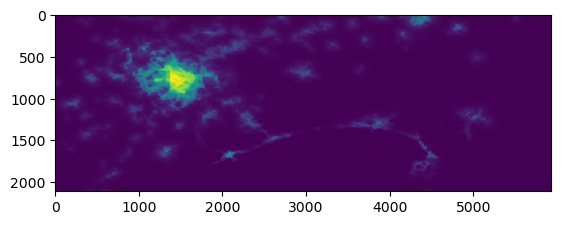

In [24]:
plt.imshow(Y)

In [25]:
Y_train = Y[:, :col_stop]
Y_test = Y[:, col_stop:]

Text(0.5, 1.0, 'Test')

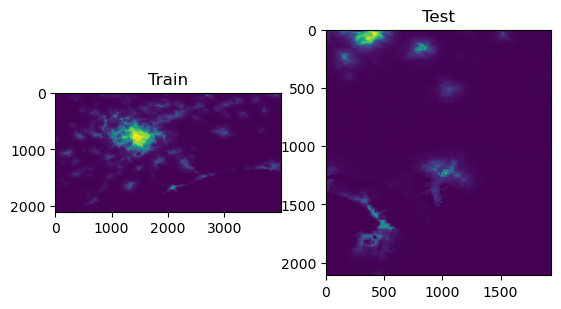

In [26]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(Y_train)
ax[0].set_title('Train')
ax[1].imshow(Y_test)
ax[1].set_title('Test')

###  Entrainement et test du modèle :

On va utiliser un modèle d'arbre de décision de la bibliothèque scikit-learn

In [27]:
from sklearn import tree

model = tree.DecisionTreeRegressor()

In [28]:
h_train, w_train, _ = X_train.shape
h_test, w_test, _ = X_test.shape

In [29]:
model = model.fit(X_train.reshape(h_train * w_train, n_c), Y_train.reshape(h_train*w_train))

In [30]:
Y_hat = model.predict(X_test.reshape(h_test * w_test, n_c)) 
Y_hat_train = model.predict(X_train.reshape(h_train * w_train, n_c))

In [31]:
Y_hat = Y_hat.reshape(h_test, w_test)
Y_hat_train = Y_hat_train.reshape(h_train, w_train)

In [32]:
np.mean(np.abs(Y_test - Y_hat))

7.7931270836320685

In [33]:
np.std(np.abs(Y_test - Y_hat))

16.02338157139423

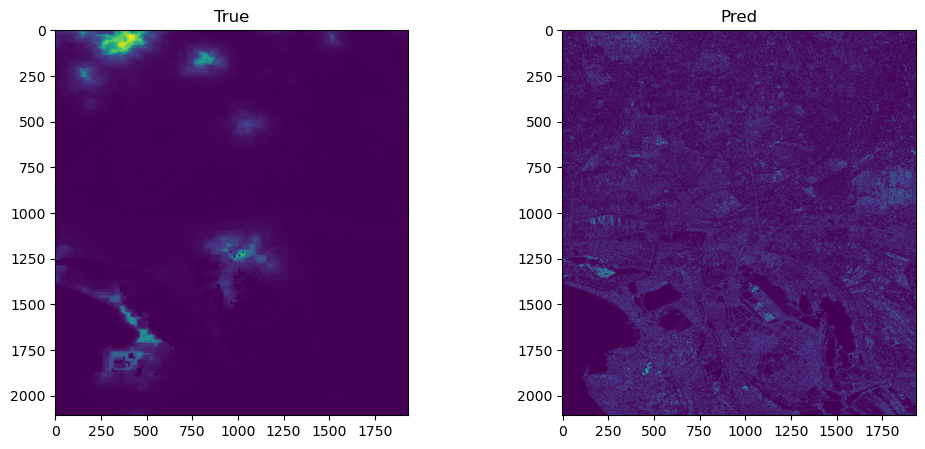

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(Y_test)
ax[0].set_title('True')
ax[1].imshow(Y_hat)
ax[1].set_title('Pred')
plt.imshow(Y_hat)

Text(0.5, 1.0, 'Pred')

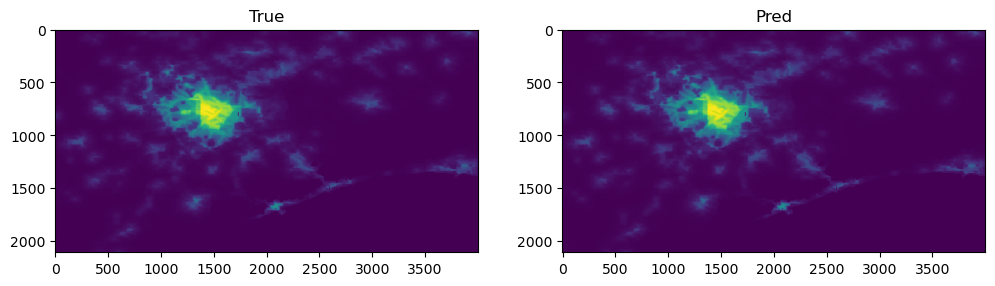

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(Y_train)
ax[0].set_title('True')
ax[1].imshow(Y_hat_train)
ax[1].set_title('Pred')

## Visualisation des réusltats

Il peut être utile d'afficher cela sur une carte pour avoir un intuition d'où sont les plus grandes erreurs. Il est assez simple de le faire. 

Il faut transformer nos tableau numpy prédit en fichier COG, que l'on pourra ensuite afficher sur la carte.

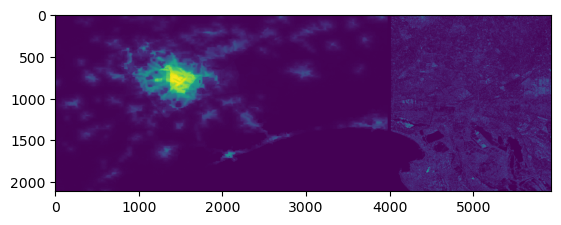

In [34]:
fusion = np.hstack([Y_hat_train, Y_hat])
fusion[:, col_stop-20:col_stop+20] = 0
plt.imshow(fusion)


In [50]:
geemap.numpy_to_cog(fusion, 'montpellier/montpellier_wp_pred_8b_10.tif', profile='montpellier/montpellier_wp_10.tif')

In [50]:
#visualization['palette']

['24126c', '1fff4f', 'd4ff50']

In [38]:
Map = geemap.Map()

Map.add_tile_layer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attribution='ESRI')
Map.add_raster('montpellier/montpellier_wp_pred_10.tif', palette='viridis', layer_name='Predictions')
Map.add_raster('montpellier/montpellier_wp_pred_8b_10.tif', palette='viridis', layer_name='Predictions 8 bands')
Map.add_raster('montpellier/montpellier_wp_10.tif', palette='viridis', layer_name='Observations')


In [39]:
Map

Map(center=[43.584640617967764, 4.007474313985597], controls=(WidgetControl(options=['position', 'transparent_…

## Références

* Wu, Q., (2020). geemap: A Python package for interactive mapping with Google Earth Engine. The Journal of Open Source Software, 5(51), 2305. https://doi.org/10.21105/joss.02305

* Wu, Q., Lane, C. R., Li, X., Zhao, K., Zhou, Y., Clinton, N., DeVries, B., Golden, H. E., & Lang, M. W. (2019). Integrating LiDAR data and multi-temporal aerial imagery to map wetland inundation dynamics using Google Earth Engine. Remote Sensing of Environment, 228, 1-13. https://doi.org/10.1016/j.rse.2019.04.015 

* Copernicus Sentinel data 2020 : https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED

* WorldPop : https://www.worldpop.org/